### Notebook setup

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

### Datasets

| Dataset             | Comment                                           | Size (clicks/size)  |
|---------------------|---------------------------------------------------|---------------------|
| train.csv           | the training set                                  | 57.537.506 / 2.5 GB |
| train_sample.csv    | sample of training set                            | 100.000 / 3.9 MB |
| test.csv            | the test set                                      | 18.790.469 / 824 MB |
| test_supplement.csv | larger test set, subset used for Kaggle evaluation | 57.537.505 / 2.5GB  |


Every click record has following associated fields:
- click_time: timestamp of click (UTC)
- ip: ip address of click
- device: device type of user mobile phone
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- app: app id for marketing

Training data contains two additional fields:
- is_attributed: was app downloaded, to be predicted
- attributed_time: time of app download

For the given click data, the goal is to output the probability that the user will download the app.


Read train and test sets for local modeling and evaluation.

In [38]:
dataset_train = pd.read_csv('data/mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv')
dataset_test = pd.read_csv('data/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv', nrows=1000000)
dataset_train['click_time'] = pd.to_datetime(dataset_train['click_time'])
dataset_test['click_time'] = pd.to_datetime(dataset_test['click_time'])
dataset_train = dataset_train.set_index('click_time')
dataset_test = dataset_test.set_index('click_time')

### Data exploration

In [23]:
dataset_train.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [24]:
for col in dataset_train:
    print(col, dataset_train[col].nunique())

ip 34857
app 161
device 100
os 130
channel 161
click_time 80350
attributed_time 227
is_attributed 2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01ac897f98>,
      dtype=object)

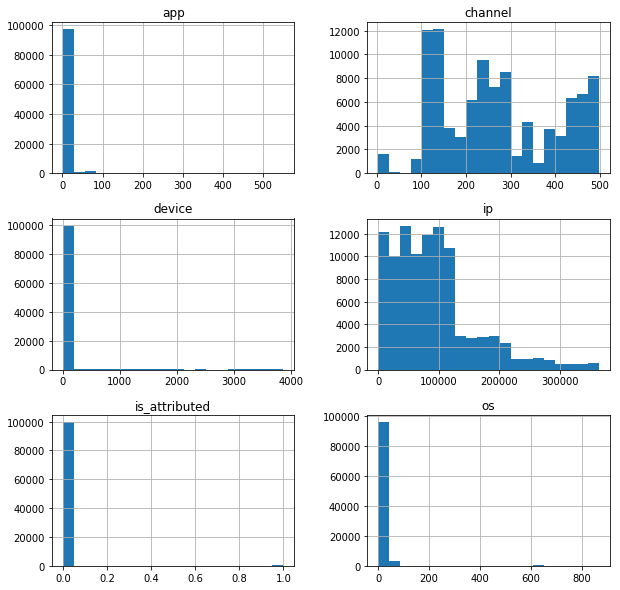

In [25]:
dataset_train.hist(bins=20, figsize=(10,10))

Distribution of `is_attributed` feature shows heavily unbalanced dataset towards no download cases.

In [26]:
corr = dataset_train.corr()
corr.style.background_gradient()

,ip,app,device,os,channel,is_attributed
ip,1,0.0103998,-0.00149891,-0.000469915,0.00756287,0.0549551
app,0.0103998,1,0.248376,0.24716,-0.0282377,0.064426
device,-0.00149891,0.248376,1,0.924456,-0.0353978,-0.000695177
os,-0.000469915,0.24716,0.924456,1,-0.0331755,0.00618346
channel,0.00756287,-0.0282377,-0.0353978,-0.0331755,1,-0.0233364
is_attributed,0.0549551,0.064426,-0.000695177,0.00618346,-0.0233364,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a5b5a20>,
      dtype=object)

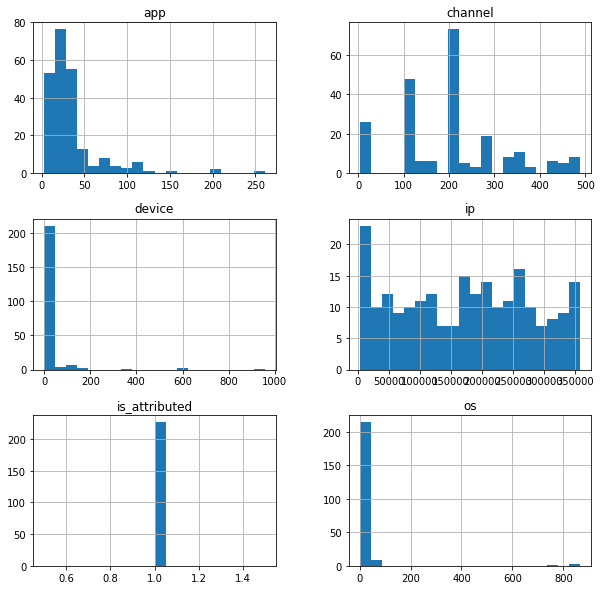

In [3]:
dataset_train[(dataset_train.is_attributed == 1)].hist(bins=20, figsize=(10,10))

In [61]:
top_apps = dataset_train.groupby(['ip'])['is_attributed'].agg(
    {"is_attributed": sum}).sort_values(
    "is_attributed", ascending=False).head(10).reset_index()
top_apps

/Users/dkomlen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,ip,is_attributed
0,5348,3
1,5314,3
2,171892,1
3,346097,1
4,29016,1
5,344369,1
6,265917,1
7,35308,1
8,344551,1
9,40654,1


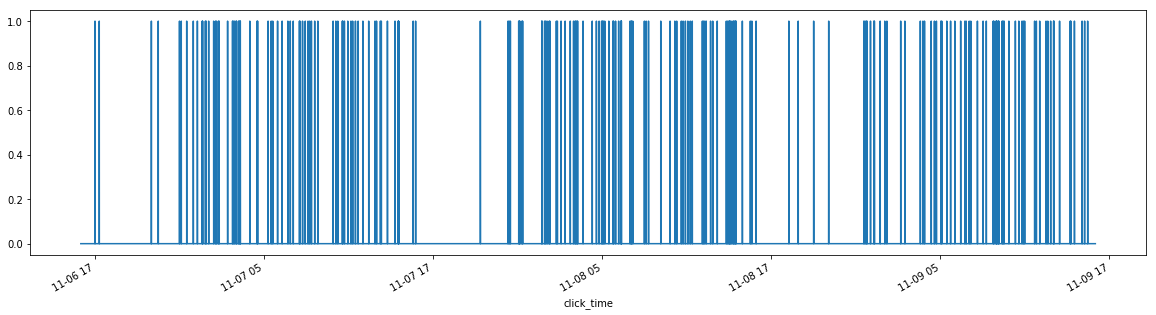

In [39]:
dataset_train.apply(lambda x: 1 if x['is_attributed'] == 1 else 0, axis=1).plot(figsize=(20, 5))

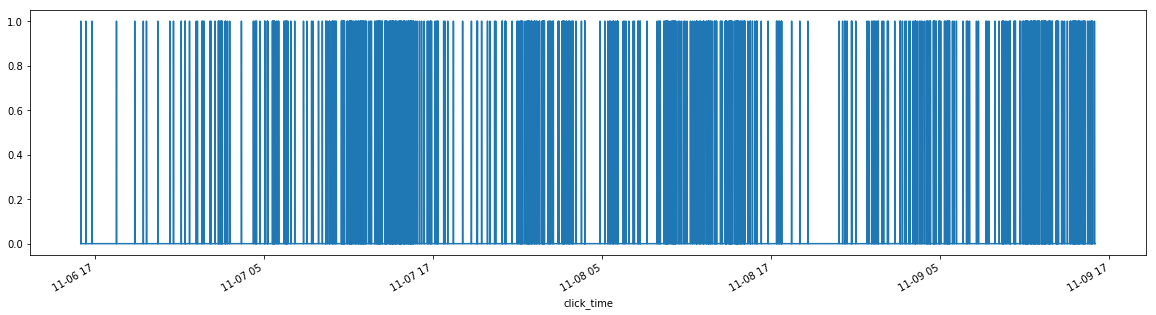

In [65]:
dataset_train.apply(lambda x: 1 if x['ip'] == 5314 else 0, axis=1).plot(figsize=(20, 5))

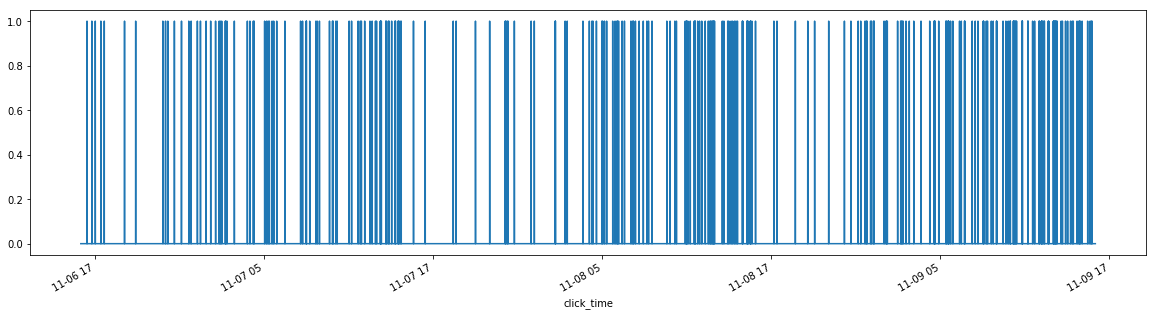

In [57]:
dataset_train.apply(lambda x: 1 if x['channel'] == 213 and x['app'] == 19 else 0, axis=1).plot(figsize=(20, 5))

### Data preparation

In [44]:
def prepare_dataset(X):
    X['hour'] = X.index.hour
    return X.drop(labels=['is_attributed', 'attributed_time', 'click_time'], axis=1, errors='ignore')

In [48]:
train_y = dataset_train['is_attributed']
train_X = prepare_dataset(dataset_train)

test_y = dataset_test['is_attributed']
test_X = prepare_dataset(dataset_test)

Additional features that we will consider adding:
- for each attribute number of clicks in previous N minutes with same attribute
value
- for each attribute time since last click with same attribute value

### Algorithms and Techniques

### Benchmark models

For benchmark we will consider two models, one outputing constant value and second using random value from uniform distribution. Both will be evaluated on test set and the one with higher score will be used as baseline.

In [8]:
benchmark_const = dataset_test[['click_id']].copy()
benchmark_const['is_attributed'] = 0
display(benchmark_const)

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
18790464,18790464,0
18790465,18790465,0
18790466,18790467,0
18790467,18790466,0


In [10]:
benchmark_rand = dataset_test[['click_id']].copy()
benchmark_rand['is_attributed'] = np.random.uniform(size=len(benchmark_rand))
display(benchmark_rand)

,click_id,is_attributed
0,0,0.236820
1,1,0.375767
2,2,0.301557
3,3,0.351115
4,4,0.535482
...,...,...
18790464,18790464,0.942351
18790465,18790465,0.181463
18790466,18790467,0.227967
18790467,18790466,0.361438


In [33]:
# Save benchmarks for evaluation on Kaggle
# benchmark_const.to_csv('data/benchmark_const.csv.gz',compression='gzip', index=False)
# benchmark_rand.to_csv('data/benchmark_rand.csv.gz',compression='gzip', index=False)

Constant model that predicts no app download scores 0.5 on Kaggle evaluator. Random model that uses uniform distribution scores 0.4995 as private score (82% of test data) and 0.5003 as public score (18% of the test data). One approach to this problem is done by [Elior Tal](https://rpubs.com/el16/410747) and his solution scores 0.825 on a subset of the test set. In his work he compares performance of random forest and boosting algorithms. We will use this as a benchmark model as it is well documented and scores better than our initial baseline models. Additionally we will use existing Kaggle solutions on the [leaderboard](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/leaderboard ) as a supporting benchmark.

### Model training

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn import tree

def evaluate_model(clf):
    predicted_proba_y = clf.predict_proba(test_X)[:,1]
    predicted_y = clf.predict(test_X)
    clf_name = str(clf).split('(')[0]
    print(clf_name + ' confusion matrix:')
    print(pd.DataFrame(confusion_matrix(test_y, predicted_y)))
    return [{'clf': clf_name,
            'auc': roc_auc_score(test_y, predicted_proba_y)}]

results = []
for clf in [LogisticRegression(), 
            GaussianNB(), 
            tree.DecisionTreeClassifier()]:
    clf.fit(train_X, train_y)
    results += evaluate_model(clf)
    
pd.DataFrame(results)

LogisticRegression confusion matrix:
        0  1
0  998306  1
1    1693  0
GaussianNB confusion matrix:
        0     1
0  994222  4085
1    1482   211
DecisionTreeClassifier confusion matrix:
        0    1
0  997702  605
1    1417  276


,auc,clf
0,0.557582,LogisticRegression
1,0.759916,GaussianNB
2,0.581209,DecisionTreeClassifier


In [9]:
# https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.externals import joblib

def optimize_model(estimator, params, cv):
    scorer = make_scorer(roc_auc_score)
    gs = GridSearchCV(estimator=estimator, param_grid=params, scoring=scorer, cv=cv)
    return gs.fit(train_X, train_y)

cv = StratifiedKFold(n_splits=5, shuffle=True)
dt_model = optimize_model(tree.DecisionTreeClassifier(), {
        'criterion' : ['gini', 'entropy'],
        'splitter': ['best', 'random']
    }, cv=cv)

nb_model = optimize_model(GaussianNB(), {}, cv=cv)

joblib.dump(nb_model, 'final_model.joblib') 
pd.DataFrame(evaluate_model(nb_model))

GridSearchCV confusion matrix:
        0     1
0  994220  4087
1    1482   211


,auc,clf
0,0.759916,GridSearchCV


### Model evaluation

In [3]:
dataset_test_all = pd.read_csv('data/test.csv')
test_all_ids = dataset_test_all['click_id']
test_all_X = prepare_dataset(dataset_test_all.drop('click_id', axis=1))

In [4]:
from sklearn.externals import joblib

clf = joblib.load('final_model.joblib') 
test_y = clf.predict_proba(test_all_X)

In [5]:
test_result = pd.DataFrame(test_y)

In [6]:
test_result = pd.DataFrame(test_y[:,1], columns=['is_attributed'])
test_result['click_id'] = test_all_ids

test_result.to_csv('data/test_result.csv.gz',compression='gzip', index=False)